## 2-pass LDA

In [2]:
import bz2
from collections import defaultdict
from datetime import datetime, timezone
import json
import logging
import os
import pickle
import re
import sys
import time

import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from gensim.models.wrappers import ldamallet

# nltk
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

# Enable LDA viz
pyLDAvis.enable_notebook()
# Enable logging for gensim
logging.basicConfig(format='%(asctime)s: %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

sys.path.append('../../../scripts-analytics/commonScripts/python/')

In [3]:
HOME = os.environ['HOME']
KEYS = f'{HOME}/config/db.json'
ENV = 'dev'
NOW = datetime.now(timezone.utc)
TODAY = NOW.date()

DATA_DIR = '../data'
MODEL_DIR = '../model'
SQL_DIR = '../sql'
OUT_DIR = '../output'

DEV = True

In [4]:
if DEV:
    RUN_DATE = '2021-04-06'
else:
    RUN_DATE = str(TODAY)
RUN_DATE

'2021-04-06'

### Helper functions

In [5]:
# Pickle a file and then compress it into a file with extension 
def compress_pickle(filepath, data):
    with bz2.BZ2File(filepath + '.pbz2', 'w') as f: 
        pickle.dump(data, f)

In [6]:
# Load any compressed pickle file
def decompress_pickle(filepath):
    data = bz2.BZ2File(filepath, 'rb')
    data = pickle.load(data)
    return data

### Load data

1. IT trends terms (dataframe)
2. Clean comments (dataframe)
3. Preprocessed comments - grouped by title (dataframe)
4. Preprocessed comments with IT trends terms - grouped by title (dataframe)
5. Topic terms and data (dictionary, keys: terms, data)  - on all data
6. Topic terms and data (dictionary, keys: terms, data)  - on data with IT trends terms

In [9]:
# clean comments
comments_df = decompress_pickle(f'{DATA_DIR}/clean_data_{RUN_DATE}.pkl.pbz2')

In [10]:
print(comments_df.shape)
comments_df.head()

(495894, 4)


,comment,title,subreddit,score
0,bold assumption team capable throwing maintain...,building jenkins pipeline,devops,8
1,comparison sense jenkins actively developed ma...,building jenkins pipeline,devops,2
2,supports plugins recreate nightmare,building jenkins pipeline,devops,4
3,reading,building jenkins pipeline,devops,2
4,nailed progression upward forward interested l...,industries life devops,devops,2


In [11]:
uniqe_titles = comments_df.title.unique()
print(comments_df.title.unique())

['building jenkins pipeline' 'industries life devops'
 'starting kubernetes 101 livestream series youtube nov 18th' ...
 'helpdesk visual dashboard display solution'
 'companies pay cloud services pay subscription type'
 'proper systemd service responsibility']


In [12]:
comments_df['comment_len'] = comments_df.comment.apply(len)

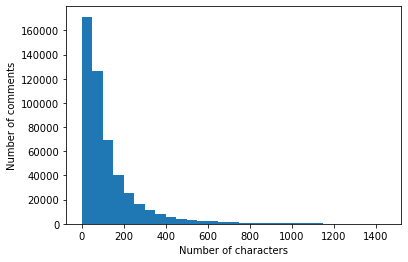

In [13]:
plt.hist(comments_df.comment_len.values, bins = range(0, 1500, 50))
plt.xlabel('Number of characters')
plt.ylabel('Number of comments')
plt.show()

In [14]:
# clean and preprocessed data having IT trends terms - grouped by title
data = decompress_pickle(f'{DATA_DIR}/grouped_titles_data_{RUN_DATE}.pkl.pbz2')

In [15]:
print(data.shape)
data.head()

(31734, 4)


,title,text,tokens,stem_text
0,,prepare artifacts push kind repository deploy...,"[prepare, artifacts, push, kind, repository, d...","[prepar, artifact, push, kind, repositori, dep..."
1,00 google hold notifications card google subs,00 google hold notifications card google subs ...,"[google, hold, notifications, card, google, su...","[googl, hold, notif, card, googl, sub, call, c..."
2,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email, account, block, powershel, access, adm..."
3,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...,"[roll, critical, account, protection, accounts...","[roll, critic, account, protect, account, high..."
4,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...,"[secret, history, windows, zipfolders, origina...","[secret, histori, window, zipfold, origin, aut..."


In [16]:
# clean and preprocessed data and terms for each topic (from 1st pass) - data with IT trends terms
topic_terms_n_data = decompress_pickle(f'{DATA_DIR}/topic_terms_n_data_{RUN_DATE}.pkl.pbz2')

In [17]:
print(topic_terms_n_data[0]['terms'])

['password', 'email', 'account', 'mail', 'mfa', 'fa', 'authent', 'outlook', 'spam', 'phish', 'send', 'phone', 'address', 'spf', 'messag', 'gmail', 'login', 'sms', 'smtp', 'app']


In [18]:
print(topic_terms_n_data[0]['data'].shape)
topic_terms_n_data[0]['data'].head(2)

(21550, 4)


,title,text,tokens,stem_text
0,,prepare artifacts push kind repository deploy...,"[prepare, artifacts, push, kind, repository, d...","[prepar, artifact, push, kind, repositori, dep..."
1,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email, account, block, powershel, access, adm..."


## Preprocessing

Note: Loaded data has been preprocessed - this is just for reference

### Tokenization


Tokenization is the process of breaking complex data (like paragraphs) into simple units called __tokens__

In [20]:
def tokenize(doc):
    for sentence in doc:
        yield(simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

### Remove stopwords

In [21]:
# stop_words = stopwords.words('english')
# len(stop_words)

In [22]:
# gist_file = f'{DATA_DIR}/gist_stopwords.txt'
# with open(gist_file, 'r') as f:
#     stop_words_from_file = f.read().split(',')

In [23]:
# stop_words.extend(stop_words_from_file)

In [24]:
# len(stop_words)

In [25]:
# def remove_stopwords(doc):
#     return doc.apply(
#         lambda sent: [word for word in sent if word not in stop_words])

### Stemming
- Stemming is a normalization technique where list of tokenized words are converted into shorter root words called stems (note: stems are not always the root word)
- Drop last letter or prefix or suffix - may not produce meaningful words
- Stemming may reduce the accuracy of the model

In [26]:
def stemming(doc, stemmer_type):
    if stemmer_type=='port':
        stemmer = PorterStemmer()
    elif stemmer_type=='snow':
        stemmer = SnowballStemmer('english')
    stemmed_text = doc.apply(
            lambda sent: [stemmer.stem(word) for word in sent])
    return stemmed_text

### Lemmatization
- Lemmatization is the morphological analysis of the words - returning meaningful words
- Requires more disk space and processing time
- Leads to higher model accuaracy
- Root word is called __lemma__

In [27]:
# lemmatizer = WordNetLemmatizer()
# def lemmatization(doc):
#     return doc.apply(
#         lambda sent: [lemmatizer.lemmatize(word) for word in sent])

In [28]:
def preprocess(data):
    # Tokenize
    tokenized_text = list(tokenize(data.text))
    data['tokens'] = tokenized_text
    # # Remove stopwords
    # nostops_text = remove_stopwords(data.tokens)
    # # print('\nWithout stopwords:\n', nostops_text[1]) 
    # data['tokens'] = nostops_text # replace with clean tokenized
    print('\nTokenized:\n', data.tokens[1])
    # Snowball stemmer
    stemmed_text = stemming(data.tokens, 'snow')
    data['stem_text'] = stemmed_text
    print('\nStemmed:\n', stemmed_text[1])
    return data

In [30]:
# # already done
# # combine all comments under the same title - prepend title

comments_grouped_by_title = comments_df.groupby(['title'])
titles = list(comments_grouped_by_title.groups.keys())
title_comments = [
    f'{title} {" ".join(comments_grouped_by_title.get_group(title).comment)}'
    for title in titles]
data = pd.DataFrame({
    'title': titles,
    'text': title_comments})
data = preprocess(data)


Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'report', 'card', 'lost', 'stolen', 'assume', 'compromised', 'testing', 'card']

Stemmed:
 ['googl', 'hold', 'notif', 'card', 'googl', 'sub', 'call', 'citibank', 'safe', 'wait', 'alert', 'suspici', 'plenti', 'disput', 'cancel', 'card', 'charg', 'today', 'odd', 'credit', 'card', 'rememb', 'straight', 'updat', 'card', 'detail', 'domain', 'registrar', 'report', 'card', 'lost', 'stolen', 'assum', 'compromis', 'test', 'card']


In [31]:
data.head()

,title,text,tokens,stem_text
0,,prepare artifacts push kind repository deploy...,"[prepare, artifacts, push, kind, repository, d...","[prepar, artifact, push, kind, repositori, dep..."
1,00 google hold notifications card google subs,00 google hold notifications card google subs ...,"[google, hold, notifications, card, google, su...","[googl, hold, notif, card, googl, sub, call, c..."
2,0365 email accounts,0365 email accounts block powershell access ad...,"[email, accounts, block, powershell, access, a...","[email, account, block, powershel, access, adm..."
3,0365 roll critical account protection accounts...,0365 roll critical account protection accounts...,"[roll, critical, account, protection, accounts...","[roll, critic, account, protect, account, high..."
4,06 secret history windows zipfolders original ...,06 secret history windows zipfolders original ...,"[secret, history, windows, zipfolders, origina...","[secret, histori, window, zipfold, origin, aut..."


In [32]:
# compress_pickle(f'{DATA_DIR}/grouped_titles_data_{RUN_DATE}.pkl', data)

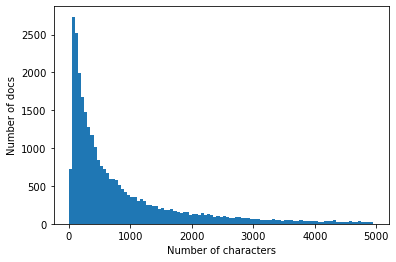

In [33]:
plt.hist(data.text.apply(len).values, bins = range(0, 5000, 50))
plt.xlabel('Number of characters')
plt.ylabel('Number of docs')
plt.show()

### Create dictionary, corpus and vectorized corpus needed for topic modeling

In [34]:
# Create dictionary representation of the documents
def build_corpus(doc, filter_extremes=True):
    doc_dict = corpora.Dictionary(doc)
    if filter_extremes:
        # Filter out words that occur in less than 20% documents, and above 50% documents
        doc_dict.filter_extremes(no_below=20, no_above=0.5)
    # Bag of words
    corpus = [doc_dict.doc2bow(text) for text in doc]
    # Compute TF-IDF score for each word in BoW (stemmed corpus)
    tfidf_mod = TfidfModel(corpus, normalize=True)
    vec_corpus = tfidf_mod[corpus]
    return doc_dict, corpus, vec_corpus, tfidf_mod

In [35]:
# Build stem corpus
(dict_stem,
 corpus_stem,
 vec_corpus_stem,
 tfid_stem_mod) = build_corpus(data.stem_text)

In [36]:
dict_stem[42]

'add'

## Topic Modeling

### Building the topic model

In [37]:
# Set training parameters.
num_topics = 7, # no. of subreddits
chunksize = 500
passes = 10
iterations = 500
eval_every = None # None - don't evaluate model perplexity, takes too much time.
workers = 6

# alpha and eta - affect sparsity of topics - defaults to 1.0/num_topics
# chunksize - control how many documents are processed at a time in training
# update_every - determined how often the parameters should be updated
# passes - total number of training passes
# iteration - control how often a particular loop is repeated over each document 
# eval_every - evaluate no. of passes and iterations
# workers - number of workers processes to be used for parallelization. 
#         - If None all available cores (as estimated by workers=cpu_count()-1 will be used

# Note - set passes and iterations high

In [38]:
# Print the keywords in the topics
def print_topics(model):
    for topic_num, words_in_topic in model.print_topics(-1):
        print(f'Topic {topic_num+1}:  Words: {words_in_topic}')

In [39]:
def print_coherence_score(model, corpus, dictionary, texts):
    # Compute Perplexity - lemmatized
    print(f'\n- Perplexity: {model.log_perplexity(corpus):.4f}')  # a measure of how good the model is. lower the better.
    # Compute Coherence Score using lemmatized comments
    coherence = CoherenceModel(
        model=model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    print(f'- Coherence Score: {coherence:.4f}')

In [40]:
# corpus - bow/tfidf dictionary of stemmed words

def build_lda(
    corpus, dictionary, corpus_type, num_topics, texts, chunksize=500, 
    passes=10, iterations=500, eval_every=None, workers=6):
    start = time.time()
    print(f'Building LDA model using {corpus_type} corpus'
          f' for {num_topics} topics...')
    mod = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=num_topics,
                       chunksize=chunksize,
                       passes=passes,
                       iterations=iterations,
                       workers=workers,
                       eval_every=eval_every)
    print(f' - {time.time()-start:.4f}s\n')
    print_topics(mod)
    print_coherence_score(mod, corpus, dictionary, texts)
    return mod

### 7 topics LDA - pass 1 - all data

In [ ]:
# 7 topic tfidf-stem corpus
lda_tfidf_stem_7top_mod = build_lda(
    corpus=vec_corpus_stem,
    dictionary=dict_stem,
    corpus_type='tfidf-stem',
    texts=data.stem_text,
    num_topics=7)

Building LDA model using tfidf-stem corpus for 7 topics...


In [ ]:
# # Save model
# compress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_mod_{RUN_DATE}.pkl', lda_tfidf_stem_7top_mod)

In [ ]:
# # # Load model
# lda_tfidf_stem_7top_mod = decompress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_mod_{RUN_DATE}.pkl.pbz2')

In [ ]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_7top_mod, vec_corpus_stem, dict_stem)
viz

In [ ]:
# # to get topic terms and data only including topic terms - already done

def get_topic_terms_n_data(df, mod, num_topics, num_terms=20):      
    topic_terms_n_data = defaultdict(dict)
    for topic_id in range(num_topics):
        print('\n**\nTopic-id:', topic_id)
        # get topic terms
        topic_terms = [
            word for word, prob in mod.show_topic(topic_id, num_terms)]
        topic_terms_n_data[topic_id]['terms'] = topic_terms
        print('\nTop terms: ', topic_terms_n_data[topic_id]['terms'])
        # get topic comments using topic_terms
        mask = df.comment.apply(lambda x: any(term for term in topic_terms if term in x))
        topic_df = df[mask]
        # combine all topic comments under the same title - prepend title
        topic_df_grouped = topic_df.groupby(['title'])
        topic_titles = list(topic_df_grouped.groups.keys())
        title_comments = [
            f'{title} {" ".join(topic_df_grouped.get_group(title).comment)}'
            for title in topic_titles]
        topic_data = pd.DataFrame({
            'title': topic_titles,
            'text': title_comments})
        # preprocess comments
        topic_data = preprocess(topic_data)
        topic_terms_n_data[topic_id]['data'] = topic_data
    return topic_terms_n_data

In [ ]:
# Perfrom LDA on topic data
sub_lda_corpus_n_mod_dict = {}
def build_sub_lda(topic_terms_n_data, num_top_topics, num_sub_topics, corpus_type):
    for topic_id in range(num_top_topics):
        print('\n**\nTop-level topic-id:', topic_id)
        print('\nTop terms: ', topic_terms_n_data[topic_id]['terms'])
        topic_text = topic_terms_n_data[topic_id]['data'].stem_text
        (topic_dict, corpus, 
         vec_corpus, tfid_mod) = build_corpus(topic_text, True)
        sub_lda_corpus_n_mod_dict[topic_id] = {
            'topic_dict': topic_dict,
            'corpus': corpus,
            'vec_corpus': vec_corpus,
            'texts': topic_text}
        if corpus_type=='tfidf-stem':
            sub_lda_corpus=vec_corpus
        elif corpus_type=='bow-stem':
            sub_lda_corpus=corpus
        print(f'\nCreating {num_sub_topics} topics...')
        sub_lda_corpus_n_mod_dict[topic_id]['mod'] = build_lda(
            corpus=sub_lda_corpus,
            dictionary=topic_dict,
            corpus_type=corpus_type,
            texts=topic_text,
            num_topics=num_sub_topics)
    return sub_lda_corpus_n_mod_dict

In [ ]:
topic_terms_n_data = get_topic_terms_n_data(comments_df, lda_tfidf_stem_7top_mod, 7, 20)

In [153]:
# compress_pickle(f'{DATA_DIR}/topic_terms_n_data_{RUN_DATE}.pkl', topic_terms_n_data)

In [ ]:
topic_terms_n_data[0]['data'][:2]

In [ ]:
topic_terms_n_data[0]['data'].shape

In [ ]:
print(topic_terms_n_data[0]['terms']) # security

In [ ]:
print(topic_terms_n_data[1]['terms']) # job & company  

In [ ]:
print(topic_terms_n_data[2]['terms']) # networking

In [ ]:
print(topic_terms_n_data[3]['terms']) # programming

In [ ]:
print(topic_terms_n_data[4]['terms']) # misc.

In [ ]:
print(topic_terms_n_data[5]['terms']) # sysadmin

In [ ]:
print(topic_terms_n_data[6]['terms']) # ML

In [61]:
# # # # replace topic you think is not relevant with the last topic
# bad_topic_terms_n_data1 = topic_terms_n_data[4] 
# topic_terms_n_data[4] = topic_terms_n_data[6]

In [201]:
# print('irrelevant topic:', bad_topic_terms_n_data1['terms'])
# print('replaced by:', topic_terms_n_data[4]['terms'])

In [85]:
# bad_topic_terms_n_data2 = topic_terms_n_data[1]
# topic_terms_n_data[1] = topic_terms_n_data[5]

In [193]:
# print('irrelevant topic:', bad_topic_terms_n_data2['terms'])
# print('replaced by:', topic_terms_n_data[5]['terms'])

### 7 topic LDA - pass2 - all data

In [ ]:
sub_lda_tfidf_stem_7top_7sub_dict = build_sub_lda(
    topic_terms_n_data, 
    7, # num top topics 
    7, # num sub topics
    'tfidf-stem') # corpus type

In [164]:
# Save 2nd pass LDA results
# compress_pickle(f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_dict_{RUN_DATE}.pkl', sub_lda_tfidf_stem_7top_7sub_dict)

In [ ]:
# # # Load 2nd pass LDA results
# sub_lda_tfidf_stem_7top_7sub_dict = decompress_pickle(
#     f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_dict_{RUN_DATE}.pkl.pbz2')

In [ ]:
print(topic_terms_n_data[0]['terms'])

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[0]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[0]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[0]['topic_dict'])
viz

In [ ]:
print(topic_terms_n_data[1]['terms'])

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[1]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[1]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[1]['topic_dict'])
viz

In [ ]:
print(topic_terms_n_data[2]['terms'])

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[2]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[2]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[2]['topic_dict'])
viz

In [ ]:
print(topic_terms_n_data[3]['terms'])

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[3]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[3]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[3]['topic_dict'])
viz

In [ ]:
print(topic_terms_n_data[4]['terms'])

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[4]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[4]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[4]['topic_dict'])
viz

In [ ]:
print(topic_terms_n_data[5]['terms'])

In [ ]:
viz = pyLDAvis.gensim.prepare(
    sub_lda_tfidf_stem_7top_7sub_dict[5]['mod'], 
    sub_lda_tfidf_stem_7top_7sub_dict[5]['vec_corpus'],
    sub_lda_tfidf_stem_7top_7sub_dict[5]['topic_dict'])
viz

____

### 7 topics LDA - pass 1 - data having IT trends terms

In [177]:
# to select data having IT Trends terms

# get comments using ittrends terms
mask = comments_df.comment.apply(lambda x: any(term for term in it_trends_df.term if term in x))
data_w_terms_df = comments_df[mask]
# combine all comments under the same title - prepend title
data_w_terms_df_grouped = data_w_terms_df.groupby(['title'])
term_titles = list(data_w_terms_df_grouped.groups.keys())
title_comments = [
    f'{title} {" ".join(data_w_terms_df_grouped.get_group(title).comment)}'
    for title in term_titles] 
term_data = pd.DataFrame({
    'title': term_titles,
    'text': title_comments})
# preprocess comments
term_data = preprocess(term_data)

compress_pickle(f'{DATA_DIR}/grouped_comments_ittrends_{RUN_DATE}.pkl', term_data)


Tokenized:
 ['google', 'hold', 'notifications', 'card', 'google', 'subs', 'called', 'citibank', 'safe', 'wait', 'alerts', 'suspicious', 'plenty', 'dispute', 'cancel', 'card', 'charges', 'today', 'odd', 'credit', 'card', 'remember', 'straight', 'update', 'card', 'details', 'domain', 'registrars', 'report', 'card', 'lost', 'stolen', 'assume', 'compromised', 'testing', 'card']

Stemmed:
 ['googl', 'hold', 'notif', 'card', 'googl', 'sub', 'call', 'citibank', 'safe', 'wait', 'alert', 'suspici', 'plenti', 'disput', 'cancel', 'card', 'charg', 'today', 'odd', 'credit', 'card', 'rememb', 'straight', 'updat', 'card', 'detail', 'domain', 'registrar', 'report', 'card', 'lost', 'stolen', 'assum', 'compromis', 'test', 'card']


In [178]:
(term_dict_stem, 
 term_corpus_stem,
 term_vec_corpus_stem,
 term_tfid_stem_mod) = build_corpus(term_data.stem_text)

In [179]:
# 7 topic tfidf-stem corpus
lda_tfidf_stem_7top_ittrends_mod = build_lda(
    corpus=term_vec_corpus_stem,
    dictionary=term_dict_stem,
    corpus_type='tfidf-stem',
    texts=term_data.stem_text,
    num_topics=7)

Building LDA model using tfidf-stem corpus for 7 topics...
 - 311.3487s

Topic 1:  Words: 0.010*"cento" + 0.008*"xss" + 0.005*"rhel" + 0.005*"hive" + 0.004*"jupyt" + 0.004*"ipynb" + 0.004*"minecraft" + 0.004*"owasp" + 0.004*"flask" + 0.004*"vba"
Topic 2:  Words: 0.039*"password" + 0.028*"email" + 0.015*"account" + 0.010*"mail" + 0.010*"phish" + 0.010*"spam" + 0.010*"fa" + 0.007*"phone" + 0.006*"messag" + 0.006*"link"
Topic 3:  Words: 0.006*"card" + 0.006*"intel" + 0.006*"game" + 0.005*"amd" + 0.005*"gpu" + 0.005*"power" + 0.005*"nvidia" + 0.005*"price" + 0.004*"perform" + 0.004*"cpu"
Topic 4:  Words: 0.012*"techsupport" + 0.011*"admx" + 0.010*"duo" + 0.004*"ftd" + 0.004*"pppoe" + 0.004*"qt" + 0.003*"activesync" + 0.003*"irb" + 0.003*"fex" + 0.003*"alphafold"
Topic 5:  Words: 0.005*"secur" + 0.005*"job" + 0.005*"compani" + 0.003*"cyber" + 0.003*"learn" + 0.003*"team" + 0.003*"cybersecur" + 0.003*"manag" + 0.003*"experi" + 0.003*"cert"
Topic 6:  Words: 0.007*"code" + 0.005*"languag" + 0.

In [194]:
# # Save model
compress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_ittrends_mod_{RUN_DATE}.pkl', lda_tfidf_stem_7top_ittrends_mod)

In [181]:
# # Load model
# lda_tfidf_stem_7top_ittrends_mod = decompress_pickle(f'{MODEL_DIR}/lda_tfidf_stem_7top_ittrends_mod_{RUN_DATE}.pkl.pbz2')

In [182]:
viz = pyLDAvis.gensim.prepare(lda_tfidf_stem_7top_ittrends_mod, term_vec_corpus_stem, term_dict_stem)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.114826  0.106220       1        1  33.016731
4      0.078874  0.035403       2        1  27.957371
5      0.115611  0.002591       3        1  18.860111
2      0.114909 -0.110247       4        1  12.697422
1     -0.170879  0.156913       5        1   3.448914
0     -0.128404 -0.099464       6        1   2.023037
3     -0.124937 -0.091417       7        1   1.996417, topic_info=             Term        Freq       Total Category  logprob  loglift
3052     password  369.000000  369.000000  Default  30.0000  30.0000
1355        email  311.000000  311.000000  Default  29.0000  29.0000
21        account  284.000000  284.000000  Default  28.0000  28.0000
3764        secur  459.000000  459.000000  Default  27.0000  27.0000
3118        phone  202.000000  202.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
4249  techsupport   46.613373   81.957886   Topic7  -4.4106   3.3495
7242         drum    5.192564    8.578281   Topic7  -6.6052   3.4118
7231       fusion    6.497484   11.689617   Topic7  -6.3810   3.3265
2600        mcafe    6.240661   16.539738   Topic7  -6.4214   2.9391
5544          tac    5.682085   16.353354   Topic7  -6.5151   2.8567

[447 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6         1  0.041327  abstract
6         2  0.061990  abstract
6         3  0.867860  abstract
16        1  0.714329    access
16        2  0.161300    access
...     ...       ...       ...
5483      4  0.946840       zen
6975      3  0.959760       zig
9334      1  0.958030   zscaler
4822      1  0.437895     zyxel
4822      6  0.517512     zyxel

[1065 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 6, 3, 2, 1, 4])

In [204]:
topic_terms_n_data_ittrends = get_topic_terms_n_data(comments_df, lda_tfidf_stem_7top_ittrends_mod, 7, 20)


**
Topic-id: 0

Top terms:  ['cento', 'xss', 'rhel', 'hive', 'jupyt', 'ipynb', 'minecraft', 'owasp', 'flask', 'vba', 'wsl', 'banner', 'ama', 'zyxel', 'wordpress', 'headless', 'selenium', 'cheatsheet', 'xilinx', 'cve']

Tokenized:
 ['amd', 'gpus', 'pro', 'pro', 'step', 'build', 'bought', 'hardware', 'ghz', 'celeron', 'geforce', 'fx', 'ofcourse', 'disappointed', 'performance', 'decided', 'sell', 'extra', 'hours', 'job', 'dish', 'washing', 'summer', 'dishwashing', 'bought', 'athlon', 'xp', 'radeon', 'pro', 'working', 'nvidia', 'nforce', 'chipset', 'amazed', 'crank', 'settings', 'play', 'smooth', 'fps', 'bios', 'flash', 'pro', 'recall', 'correctly', 'prices', 'high', 'cpu', 'gpu', 'times', 'buy', 'hardware']

Stemmed:
 ['amd', 'gpus', 'pro', 'pro', 'step', 'build', 'bought', 'hardwar', 'ghz', 'celeron', 'geforc', 'fx', 'ofcours', 'disappoint', 'perform', 'decid', 'sell', 'extra', 'hour', 'job', 'dish', 'wash', 'summer', 'dishwash', 'bought', 'athlon', 'xp', 'radeon', 'pro', 'work', 'nvidi

In [205]:
compress_pickle(f'{DATA_DIR}/topic_terms_n_data_ittrends_{RUN_DATE}.pkl', topic_terms_n_data_ittrends)

In [206]:
print(topic_terms_n_data_ittrends[0]['terms'])

['cento', 'xss', 'rhel', 'hive', 'jupyt', 'ipynb', 'minecraft', 'owasp', 'flask', 'vba', 'wsl', 'banner', 'ama', 'zyxel', 'wordpress', 'headless', 'selenium', 'cheatsheet', 'xilinx', 'cve']


In [207]:
print(topic_terms_n_data_ittrends[1]['terms'])

['password', 'email', 'account', 'mail', 'phish', 'spam', 'fa', 'phone', 'messag', 'link', 'googl', 'address', 'spf', 'hack', 'send', 'scam', 'breach', 'login', 'compromis', 'gmail']


In [208]:
print(topic_terms_n_data_ittrends[2]['terms'])

['card', 'intel', 'game', 'amd', 'gpu', 'power', 'nvidia', 'price', 'perform', 'cpu', 'chip', 'laptop', 'core', 'gb', 'buy', 'hardwar', 'appl', 'cabl', 'nm', 'ram']


In [209]:
print(topic_terms_n_data_ittrends[3]['terms'])

['techsupport', 'admx', 'duo', 'ftd', 'pppoe', 'qt', 'activesync', 'irb', 'fex', 'alphafold', 'fmc', 'bookstack', 'nordvpn', 'tcam', 'imessag', 'lmgtfi', 'es', 'recap', 'openldap', 'nb']


In [210]:
print(topic_terms_n_data_ittrends[4]['terms'])

['secur', 'job', 'compani', 'cyber', 'learn', 'team', 'cybersecur', 'manag', 'experi', 'cert', 'engin', 'devop', 'start', 'person', 'interview', 'skill', 'degre', 'day', 'work', 'busi']


In [211]:
print(topic_terms_n_data_ittrends[5]['terms'])

['code', 'languag', 'model', 'paper', 'learn', 'python', 'program', 'data', 'write', 'github', 'project', 'train', 'imag', 'function', 'dataset', 'video', 'librari', 'articl', 'compil', 'develop']


In [212]:
print(topic_terms_n_data_ittrends[6]['terms'])

['server', 'window', 'user', 'file', 'updat', 'network', 'connect', 'instal', 'devic', 'switch', 'vpn', 'microsoft', 'domain', 'set', 'access', 'port', 'log', 'servic', 'router', 'dns']


####  All topics look relevant - no topic was replaced

### 7 topic LDA - pass2 - data having IT trends terms

In [ ]:
# sub_lda_tfidf_stem_7top_7sub_ittrends_dict = build_sub_lda(
#     topic_terms_n_data_ittrends, 
#     7, # num top topics
#     7, # num sub topics
#     'tfidf-stem') # corpus type

In [ ]:
# # Save 2nd pass LDA results
# compress_pickle(f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_ittrends_dict_{RUN_DATE}.pkl', sub_lda_tfidf_stem_7top_7sub_ittrends_dict)

In [ ]:
# # Load 2nd pass LDA results
# sub_lda_tfidf_stem_7top_7sub_ittrends_dict = decompress_pickle(f'{MODEL_DIR}/sub_lda_tfidf_stem_7top_7sub_ittrends_dict_{RUN_DATE}.pkl.pbz2')

In [ ]:
# print(topic_terms_n_data_ittrends[0]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[0]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[0]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[0]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[1]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[1]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[1]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[1]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[2]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[2]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[2]['corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[2]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[3]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[3]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[3]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[3]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[4]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[4]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[4]['corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[4]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[5]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[5]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[5]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[5]['topic_dict'])
# viz

In [ ]:
# print(topic_terms_n_data_ittrends[6]['terms'])

In [ ]:
# viz = pyLDAvis.gensim.prepare(
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[6]['mod'], 
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[6]['vec_corpus'],
#     sub_lda_tfidf_stem_7top_7sub_ittrends_dict[6]['topic_dict'])
# viz